## CS342 Assignment

### Student ID: 2101456

---

In [1]:
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [2]:
# Load dataset and preprocess
circles = pd.read_csv("circles.data", header=None)
x = circles.iloc[:, :2].values
y = circles.iloc[:, 2].values

In [3]:
# Define the Gaussian Kernel
def gaussian_kernel(N, sigma):
    n = len(N) # Find the size of K
    K = np.zeros((n, n)) # Initialise K
    x = np.matrix(N)
    # Compute each entry separetly, recall that Gaussien matrix is K(xi, xj) = exp(-(1/2*sigma**2)||xi-xj||^2), 
    for i in range(n):
        for j in range(n):
            K[i][j] = np.exp(-(1 / (2*sigma**2))*(np.linalg.norm(x[i] - x[j], ord = 2))**2)
    return K

# Similarly, define the Homogeneous Polynomial Kernel
def polynomial_kernel(N, d):
    n = len(N)
    K = np.zeros((n, n))
    x = np.matrix(N)
    # Compute each entry separetly, recall that Homogeneous Polynomial kernel is K(xi, xj) = (<xi, xj>)^degree,
    for i in range(n):
        for j in range(n):
            K[i][j] = (np.inner(x[i], x[j]))**d
    return K


# Define the PCA function, n_pc represents the number of PCs used.
def PCA(K, n_pc): # Requst to input kernel matrix and the number of PCs.
    n = len(K)# Computing the length
    
    ### Computing and normalizing the centred matrix
    
    ## Creating a matrix of ones divided by n (One_n)
    # This line creates an n x n matrix where each element is 1/n.This matrix is used for centering the kernel matrix.
    One_over_n = np.ones((n, n)) / n 
    
    ## Centering the kernel matrix (K_centered)
    # The centering is done by subtracting the row mean and the column mean 
    # from each element of the kernel matrix and then adding the overall mean.
    # 'One_n @ K' computes the average of each column.
    # 'K @ One_n' computes the average of each row.
    # 'One_n @ K @ One_n' computes the overall average.
    K_centered = (K - One_over_n @ K - K @ One_over_n + One_over_n @ K @ One_over_n)
    
    ## Normalizing the centered kernel matrix (K_centered_normalize):
    K_normalized = K_centered / (n-1)
    
    
    ### Eigenvalues Decomposition:
    # Computes the eigenvalues (SIGMA) and eigenvectors (U) of the centered and normalized kernel matrix.
    SIGMA, U = np.linalg.eigh(K_normalized)
    
    # Takes the absolute value of the eigenvalues. 
    # This is important as PCA assumes variance (eigenvalues) is non-negative.
    S = np.abs(SIGMA)
    
    ### Sorting eigenvectors according to eigenvalues:
    # Combines eigenvectors with their corresponding eigenvalues, 
    # sorts them in descending order of the eigenvalues, and then separates them again.
    U_eivectors = np.concatenate((np.array(U).T, S.reshape(-1, 1)), axis = 1)
    U_decreasing = np.array(sorted(U_eivectors, key = lambda x: x[-1], reverse = True))[:, :-1].T
    
    ### Sorting Eigenvalues and Creating Sigma Matrix:
    ## Sorts the absolute eigenvalues in descending order.
    S_sorted = sorted(S, reverse = True)
    
    ## Constructs the diagonal matrix Sigma with the square roots of the sorted eigenvalues, representing singular values.
    Sigma = np.diag(np.sqrt(np.array(S_sorted)))
    
    ### Projecting Data Onto Principal Components:
    # Projects the data onto the top n_pc principal components.
    # This is done by multiplying the sorted eigenvectors (U_decresing) with the first n_pc columns of Sigma.
    # The factor (n - 1) is a scaling factor related to the normalization of the kernel matrix.
    P = (n - 1) * np.array(U_decreasing[:, :n_pc]) @ np.array(Sigma[:, :n_pc][:n_pc])
    
    return np.matrix(P)

A method described for using PCA (Principal Component Analysis) for linear separability assessment in a binary classification problem can bee ussed here by several steps. 

1. Projection onto Principal Components (PCs):

PCA is used to reduce the dimensionality of the data. Each principal component represents a direction in the data that maximizes variance. The PCA function described earlier is used for this purpose.
The data is projected onto the top n_pc principal components. In this case, I've found that only 3 principal components (n_pc) and a specific sigma value (7) are necessary.

2. Class Separation in Projected Data:

For the samples in circles.data, the first 250 samples belong to Class 1 and the rest to Class 2.
For each principal component, calculating the minimum and maximum values of the projected data for each class.

3. Assessing Linear Separability:

Linear separability is assessed by examining the $min_1(Class1)$ & $max_1(Class1)$ and $min_2(Class2)$ & $max_2(Class2)$ values.
If $min_1 > max_2$ or $max_1 < min_2$, it indicates that there is no overlap between the two classes along that principal component.
This means you can draw a straight line (or, in higher dimensions, a hyperplane) that completely separates the two classes along that principal component.

4. Decision Stump as a Classifier:

A decision stump is a simple decision tree with only one decision.
The point of separation (where you would draw the line) is calculated as the average of the overlapping boundaries: $(min_1 + max_2)/2$ or $(max_1 + min_2)/2$.
This point is used as the threshold for classification along that principal component.

At the begaining the range of n_pc and sigma were both range(1, 11). But for only 3 PCs and sigma=7 work the best, therefore I reduced the range for testing for n_pc to save time. 

In [4]:
### For-Loops for n_pc and Sigma:
# The outer loop iterates over a range of values for the number of top principal components (1 to 3 in your case).
# The inner loop iterates over a range of sigma values (1 to 10) for the Gaussian kernel.
# These loops are used to explore different combinations of n_pc and sigma to find the best setting for class separation.
# Since the runtime for this cell is too long so I have adjust the range of n_pc and sigma, based on the final answer.
for n_pc in range(1, 4): 
    for sigma in range(3, 8):
        
        ### PCA projection:
        PCA_gaussian = PCA(gaussian_kernel(x, sigma), n_pc)
        
        ### Extracting the feature vector:
        # This line extracts the feature vector corresponding to the n_pc-th principal component from the projected data P_gaussian.
        PCA_n = PCA_gaussian[:, (n_pc - 1)]

        ### Calculating maxmums and minimums:
        max_1 = max(PCA_n[:250])
        min_1 = min(PCA_n[:250])
        max_2 = max(PCA_n[250:500])
        min_2 = min(PCA_n[250:500])
        
        ### Checking for Linear Separability:
        # The code checks if the classes are linearly separable along the n_pc-th principal component.
        # If min_1 > max_2, it means Class 1 is entirely on the higher side compared to Class 2 along this component, thus linearly separable.
        # If max_1 < min_2, it means Class 1 is entirely on the lower side compared to Class 2, again indicating linear separability.
        if min_1 > max_2:
            print('The number of top PCs =', n_pc, '. The sigma of the Gaussian Kernel =', sigma, '. The threshold =', (min_1 + max_2) / 2,
                  '. Classify to Class 2 if feature < threshold.')
            break
        elif max_1 < min_2:
            print('The number of top PCs =', n_pc, '. The sigma of the Gaussian Kernel =', sigma, '. The threshold =', (max_1 + min_2) / 2,
                  '. Classify to Class 1 if feature < threshold.')
            break
    ### Breaking the Loop:
    # If a combination of n_pc and sigma is found that achieves linear separability, the loops are exited after printing the result.
    # If not broken, this means the samples are unable to be linealy sperated.
    else:
        print('Cannot be linearly separated with Gaussian Kernel')
        continue

Cannot be linearly separated with Gaussian Kernel
Cannot be linearly separated with Gaussian Kernel
The number of top PCs = 3 . The sigma of the Gaussian Kernel = 7 . The threshold = [[-1.27100821]] . Classify to Class 1 if feature < threshold.


Therefore 3 PCs are enough to do linearly seperation with the specific sigma (7). Additionally, there is no need to run for a larger n_pc of PCs, since we are finding the smallest.

We do the similar process again to see the PCS with homogeneous polynomial kernel.

In [5]:
for n_pc in range(1, 4): 
    for sigma in range(3, 8):
        
        PCA_gaussian = PCA(polynomial_kernel(x, sigma), n_pc)
        
        
        PCA_n = PCA_gaussian[:, (n_pc - 1)]

        ### Calculating maxmums and minimums:
        max_1 = max(PCA_n[:250])
        min_1 = min(PCA_n[:250])
        max_2 = max(PCA_n[250:500])
        min_2 = min(PCA_n[250:500])
        
        ### Checking for Linear Separability:
        # The code checks if the classes are linearly separable along the n_pc-th principal component.
        # If min_1 > max_2, it means Class 1 is entirely on the higher side compared to Class 2 along this component, thus linearly separable.
        # If max_1 < min_2, it means Class 1 is entirely on the lower side compared to Class 2, again indicating linear separability.
        if min_1 > max_2:
            print('The number of top PCs =', n_pc, '. The degree of the homogeneous polynomial kernel =', sigma, '. The threshold =', (min_1 + max_2) / 2,
                  '. Classify to Class 2 if feature < threshold.')
            break
        elif max_1 < min_2:
            print('The number of top PCs =', n_pc, '. The degree of the homogeneous polynomial kernel =', sigma, '. The threshold =', (max_1 + min_2) / 2,
                  '. Classify to Class 1 if feature < threshold.')
            break
    ### Breaking the Loop:
    # If a combination of n_pc and sigma is found that achieves linear separability, the loops are exited after printing the result.
    # If not broken, this means the samples are unable to be linealy sperated.
    else:
        print('Cannot be linearly separated with polynomial kernel')
        continue

Cannot be linearly separated with polynomial kernel
Cannot be linearly separated with polynomial kernel
Cannot be linearly separated with polynomial kernel


In [6]:
# Define the decesion tree
# This function, decesion_stump, takes a feature and a threshold value.
# It compares each element in feature to the threshold. If an element is greater than the threshold, it assigns a label 2 (True (1) + 1), otherwise, it assigns a label 1 (False (0) + 1).
# This binary classification mechanism is the essence of a decision stump - a simple decision tree with just one decision node.
def decesion_stump(feature, threshold):
    decision = (feature > threshold).astype(int) + 1
    return decision
# Feature extraction using PCA and gaussian kernel and threshold setting and prediction::
feature = np.array(PCA(gaussian_kernel(x, 7), 3)[:, 2])
threshold = -1.27100821
y_predict = decesion_stump(feature, threshold) 

# Calculate the accuracy of the decision stump on the projection.
accuracy = accuracy_score(np.array(y), y_predict)
print(f'The accuracy is {100*accuracy}%')

The accuracy is 100.0%


In [7]:
# Classify the samples
samples = np.array(PCA(gaussian_kernel(x, 7), 3))
samples_1 = samples[:250]
samples_2 = samples[250:500]
feature = np.array(PCA(gaussian_kernel(x, 7), 3)[:, 2])
threshold = -1.27100821

In [8]:
# Find the projected data in 2-D space and then draw the picture for visualizing of the projection and the decision stump
# Extracting coordinates for the two sets.
feature_1, feature_2 = samples_1[:, 1], samples_1[:, 2]
feature_3, feature_4 = samples_2[:, 1], samples_2[:, 2]

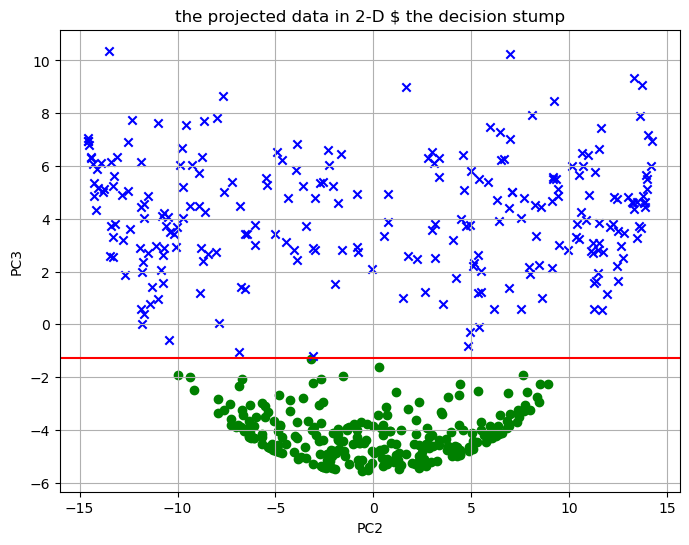

In [9]:
# Plot the scatter graph of samples in 2-D.
# Plot the first class and second class separetaly and in different colour. Green-class 1 Blue-class 2
# Also shows the decision stump
plt.figure(figsize = (8,6))
plt.scatter(feature_1, feature_2, c = 'g', marker = 'o')
plt.scatter(feature_3, feature_4, c = 'b', marker = 'x')
plt.axhline(y = threshold, color = 'r', linestyle = '-', label = 'Decision Stump')
plt.title('the projected data in 2-D $ the decision stump')
plt.xlabel('PC2')
plt.ylabel('PC3')
plt.grid(True)
plt.show()

In [10]:
# Find the projected data in 3-D space and then draw the picture for visualizing of the projection and the decision stump
# Extracting 3-D coordinates for the two sets.
feature_1, feature_2, feature_3 = samples_1[:, 0], samples_1[:, 1], samples_1[:, 2]
feature_4, feature_5, feature_6 = samples_2[:, 0], samples_2[:, 1], samples_2[:, 2]

C:\Users\Yuxin\AppData\Local\Temp\ipykernel_2776\1492419741.py:20: UserWarning: The handle <mpl_toolkits.mplot3d.art3d.Path3DCollection object at 0x000001F91F9E2D30> has a label of '_child0' which cannot be automatically added to the legend.
  ax.legend(handles=[class1, class2, legend])
C:\Users\Yuxin\AppData\Local\Temp\ipykernel_2776\1492419741.py:20: UserWarning: The handle <mpl_toolkits.mplot3d.art3d.Path3DCollection object at 0x000001F91F9F0220> has a label of '_child1' which cannot be automatically added to the legend.
  ax.legend(handles=[class1, class2, legend])


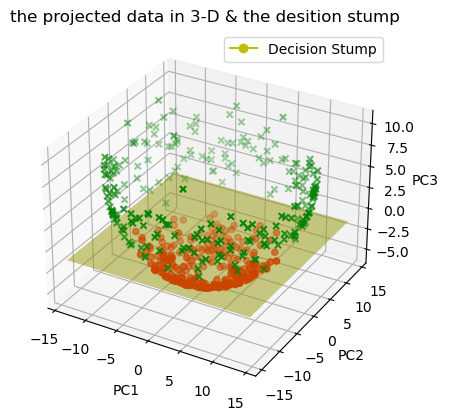

In [11]:
# Plot the scatter graph of samples in 3-D. By create a single 3D scatter plot.
# Plot the first class and second class separetaly and in different colour. Green-class 1 Blue-class 2
# Also shows the decision stump which is a flat surface.
fig = plt.figure()
ax = fig.add_subplot(111, projection = '3d')

class1 = ax.scatter(feature_1, feature_2, feature_3, c = 'r', marker = 'o')
class2 = ax.scatter(feature_4, feature_5, feature_6, c = 'g', marker = 'x')
# The Decision Stump
x = np.linspace(min(samples[:, 0]), max(samples[:, 0]), 250)
y= np.linspace(min(samples[:, 1]), max(samples[:, 1]), 250)
X, Y = np.meshgrid(x, y)
Z = np.full_like(X, threshold)
decision_stump = ax.plot_surface(X, Y, Z, alpha = 0.5, color = 'y')
legend = plt.Line2D([0], [0], c = 'y', marker = 'o', label = 'Decision Stump')
plt.title('the projected data in 3-D & the desition stump')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.legend(handles=[class1, class2, legend])
plt.show()